In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import accuracy_score

random_state = 42

In [2]:
data = pd.read_csv('./exam_2021_01_15.csv')
data.head()

,A0,A1,A2,y
0,2067.582042,-15.259519,0.020472,2
1,1319.589579,-18.412320,0.521308,0
2,1170.212183,-19.470602,0.814986,0
3,1424.162191,9.867841,0.848751,1
4,1551.069098,11.809364,0.884964,1


In [3]:
X = data.drop('y', axis=1)
y = data['y']
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (1000, 3), y shape: (1000,)


In [4]:
data.describe()

,A0,A1,A2,y
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1489.096297,-7.166652,0.505010,0.999000
std,274.553828,13.077564,0.293416,0.817109
min,690.679955,-22.833984,0.000412,0.000000
25%,1295.382256,-17.161708,0.246973,0.000000
50%,1495.200642,-14.249017,0.518429,1.000000
75%,1676.991938,9.600518,0.766703,2.000000
max,2185.753771,17.595486,0.999833,2.000000


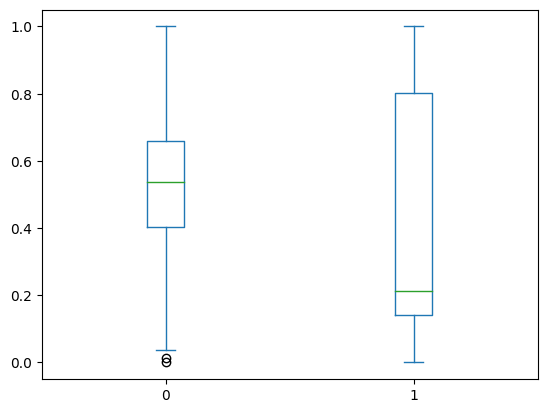

In [29]:
X.plot.box();

In [6]:
X = X[['A0','A1']]
X = pd.DataFrame(MinMaxScaler().fit_transform(X))

In [ ]:
X.plot.box();

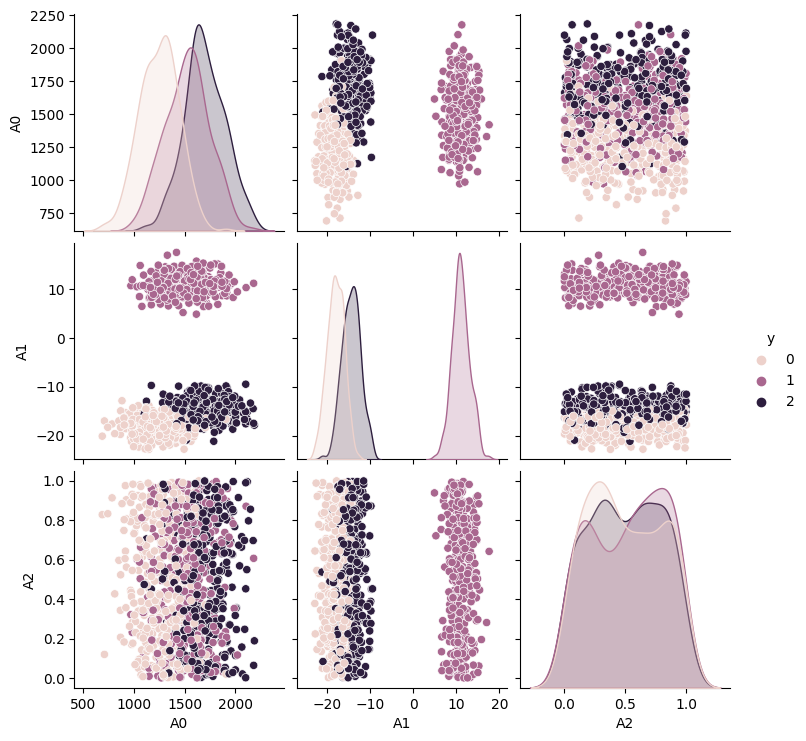

In [7]:
sns.pairplot(data, hue='y');

In [13]:
def transform(y_true, y_pred):
        y_mapped = y_pred.copy()
        for lab in np.unique(y_pred):
            if lab in y_true:
                true_l, count = np.unique(y_true[y_pred==lab], return_counts=True)
                y_mapped[y_pred==lab] = true_l[np.argmax(count)]
            else:
                y_mapped[y_pred==lab] = lab
        return y_mapped 

In [52]:
params = [{'n_components':range(2,4), 'max_iter':range(100,500,10), 'n_init':range(1,4), 'init_params':['kmeans', 'k-means++', 'random']}]
parameters = list(ParameterGrid(params))
results = []
for i in range(len(parameters)):
    parameter = parameters[i]
    gaussian_mixture = GaussianMixture(**(parameter), random_state=random_state)
    y_predicted = gaussian_mixture.fit_predict(X)
    if len(np.unique(y_predicted)) > 1:
        row = parameter.copy()
        silhouette_value = silhouette_score(X, y_predicted)
        accuracy_value = accuracy_score(y, transform(y, y_predicted))
        row['silhouette'] = silhouette_value
        row['accuracy'] = accuracy_value
        row['i'] = i
        results.append(row)

clustering_results = pd.DataFrame(results)


In [53]:
clustering_results.sort_values(by=['accuracy','silhouette'], inplace=True, ascending=False)
clustering_results.head()

,init_params,max_iter,n_components,n_init,silhouette,accuracy,i
3,kmeans,100,3,1,0.570407,0.96,3
4,kmeans,100,3,2,0.570407,0.96,4
5,kmeans,100,3,3,0.570407,0.96,5
9,kmeans,110,3,1,0.570407,0.96,9
10,kmeans,110,3,2,0.570407,0.96,10


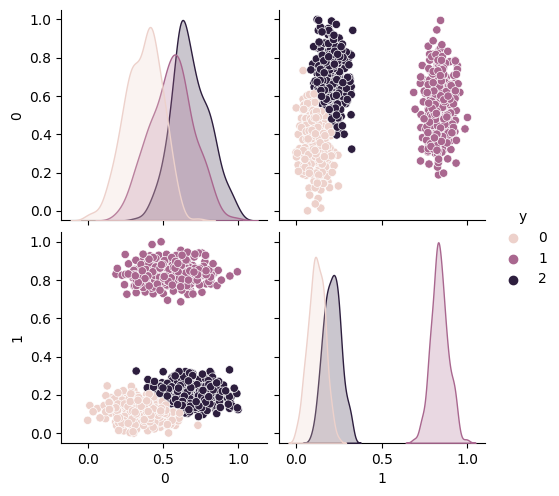

In [55]:
best_parameter = parameters[clustering_results.iloc[0]['i']]
best_gaussian_mixture = GaussianMixture(**(best_parameter),random_state=random_state)
y_gaussian_mixutre = best_gaussian_mixture.fit_predict(X)
data_plot = pd.DataFrame(X.copy())
data_plot['y'] = transform(y, y_gaussian_mixutre)
sns.pairplot(data_plot, hue='y');


In [56]:
params = [{'n_clusters':range(2,4), 'metric':['euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 'linkage':['ward', 'complete', 'average', 'single']}]
parameters = list(ParameterGrid(params))
results = []
for i in range(len(parameters)):
    parameter = parameters[i]
    if parameter['linkage'] == 'ward' and parameter['metric'] != 'euclidean':
        continue
    agglomerative = AgglomerativeClustering(**(parameter))
    y_predicted = agglomerative.fit_predict(X)
    row = parameter.copy()
    silhouette_value = silhouette_score(X, y_predicted)
    accuracy_value = accuracy_score(y, transform(y, y_predicted))
    row['silhouette'] = silhouette_value
    row['accuracy'] = accuracy_value
    row['i'] = i
    results.append(row)

clustering_results = pd.DataFrame(results)
clustering_results.sort_values(by=['accuracy','silhouette'], inplace=True, ascending=False)
clustering_results.head()

,linkage,metric,n_clusters,silhouette,accuracy,i
13,average,euclidean,3,0.587214,0.940,21
17,average,l2,3,0.587214,0.940,25
1,ward,euclidean,3,0.589437,0.922,1
5,complete,l1,3,0.586575,0.913,13
9,complete,manhattan,3,0.586575,0.913,17


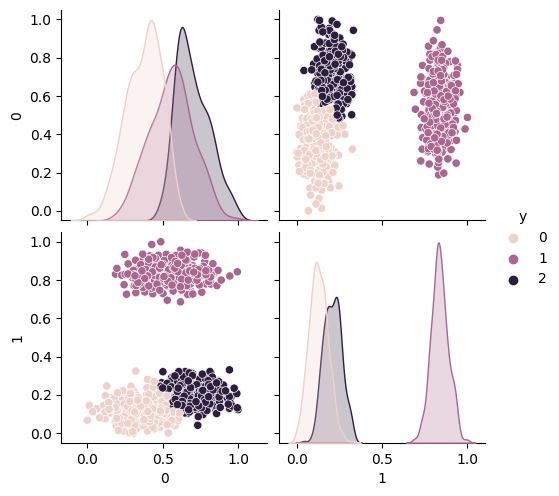

In [58]:
best_parameter = parameters[clustering_results.iloc[0]['i']]
best_agglomerative = AgglomerativeClustering(**(best_parameter))
y_agglomerative = best_agglomerative.fit_predict(X)
data_plot = pd.DataFrame(X.copy())
data_plot['y'] = transform(y, y_agglomerative)
sns.pairplot(data_plot, hue='y');

In [59]:
def k_distance(X, k):

	k_distances = []
	for i in range(0, X.shape[0]):
		k_point_distances = []
		for j in range(0, X.shape[0]):
			if i!=j:
				dist = np.sqrt(sum((X[i,:]-X[j,:])**2))
				k_point_distances.append(dist)
		k_point_distances.sort()
		k_distances.append(k_point_distances[k-1])
		
	k_distances.sort(reverse=True)
	return k_distances

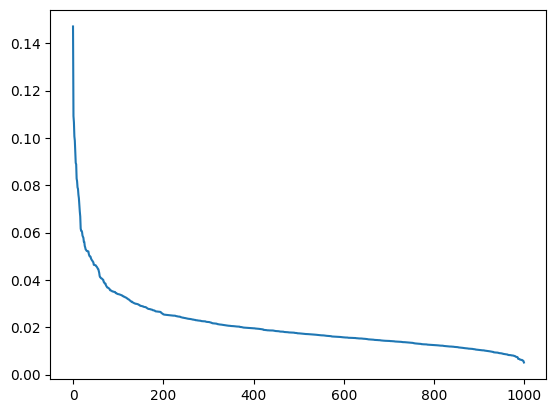

In [64]:
distances = k_distance(np.array(X), 4)
plt.plot(range(len(distances)),distances)
plt.show()

In [69]:
params = [{'eps':np.arange(0.2,0.7,0.1), 'min_samples':range(2,7)}]
parameters = list(ParameterGrid(params))
results = []
for i in range(len(parameters)):
    parameter = parameters[i]
    dbscan = DBSCAN(**(parameter))
    y_predicted = dbscan.fit_predict(X)
    n_clusters = len(np.unique(y_predicted[y_predicted != -1]))
    if n_clusters > 1:
        row = parameter.copy()
        silhouette_value = silhouette_score(X, y_predicted)
        accuracy_value = accuracy_score(y, transform(y, y_predicted))
        row['silhouette'] = silhouette_value
        row['accuracy'] = accuracy_value
        row['n_clusters'] = n_clusters
        row['i'] = i
        results.append(row)

clustering_results = pd.DataFrame(results)

In [70]:
clustering_results = pd.DataFrame(results)
clustering_results.sort_values(by=['accuracy','silhouette'], inplace=True, ascending=False)
clustering_results.head()

,eps,min_samples,silhouette,accuracy,n_clusters,i
0,0.2,2,0.679219,0.667,2,0
1,0.2,3,0.679219,0.667,2,1
2,0.2,4,0.679219,0.667,2,2
3,0.2,5,0.679219,0.667,2,3
4,0.2,6,0.679219,0.667,2,4


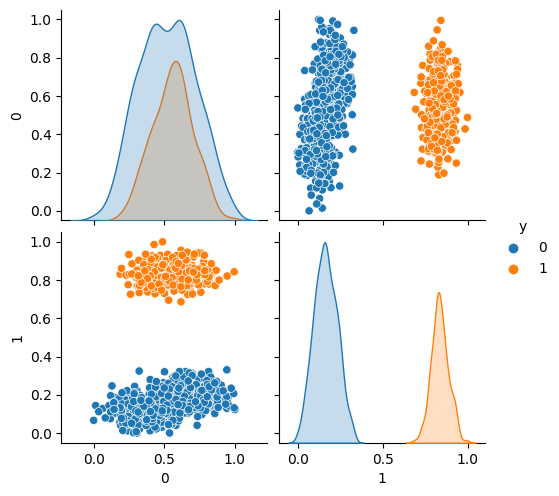

In [73]:
best_parameter = parameters[int(clustering_results.iloc[0]['i'])]
best_dbscan = DBSCAN(**(best_parameter))
y_dbscan = best_dbscan.fit_predict(X)
data_plot = pd.DataFrame(X.copy())
data_plot['y'] = transform(y, y_dbscan)
sns.pairplot(data_plot, hue='y');